In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
#suppress warnings
warnings.filterwarnings('ignore')

import scipy.io
import math


In [2]:
from google.colab import drive

drive.mount('/content/drive')

%pwd
%cd "/content/drive/MyDrive/Colab Notebooks/Taller 2 Red Neuronal"
%pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Taller 2 Red Neuronal


'/content/drive/MyDrive/Colab Notebooks/Taller 2 Red Neuronal'

In [3]:
from RandParametros import randParametros
from fming import fmincg
from organizarBeta import organizarBeta


In [4]:
mat = scipy.io.loadmat('datos4.mat')
x_data = mat['X'];
y_data = mat['y'];
#print(x_data[0,:])

In [5]:
#Saber que hay en la matriz y data

print(y_data)

[[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]


[9]


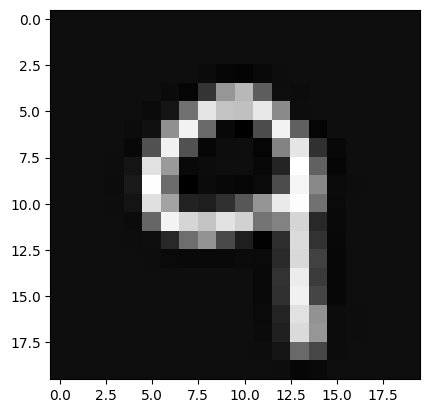

In [6]:
cont = 0
DatSetImage = np.zeros((20,20))
ImageNumber = 4850

for i in range(20):
  for j in range(20):
    DatSetImage[j,i] = x_data[ImageNumber,cont]
    cont+=1

plt.imshow(DatSetImage,cmap='gray')
print(y_data[ImageNumber])

In [7]:
#Dividir datos en Entrenamiento en 70% y 30%

x_dat_70 = []
y_dat_70 = []

for i in range(0, 5000, 500):
    x_dat70 = x_data[i:i+350, :]
    x_dat_70.append(x_dat70)
    y_dat70 = y_data[i:i+350, :]
    y_dat_70.append(y_dat70)

x_data_70 = np.concatenate(x_dat_70, axis=0)
y_data_70 = np.concatenate(y_dat_70, axis=0)

x_data_30 = np.zeros((1500, 400))
y_data_30 = np.zeros((1500, 1))
posicion = 0

for j in range(500, 5500, 500):
  x_dat30 = x_data[j-150:j, :]
  x_data_30[posicion:posicion+150, :] = x_dat30
  y_dat30 = y_data[j-150:j, :]
  y_data_30[posicion:posicion+150, :] = y_dat30
  posicion += 150

#x_data_30 =
#y_data_30 =

#x_data_70 =
#y_data_70 =

#Calcular la m a partir de x_data_30

In [8]:
print(y_data[500,0])
print(y_data_70[499,0])
print(y_data_30[149,0])

1
1
10.0


[10]


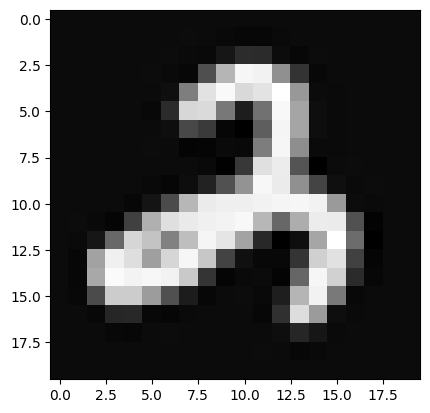

In [9]:
cont = 0
DatSetImage = np.zeros((20,20))
ImageNumber = 350

for i in range(20):
  for j in range(20):
    DatSetImage[j,i] = x_data_30[ImageNumber,cont]
    cont+=1

plt.imshow(DatSetImage,cmap='gray')
print(y_data[ImageNumber])

In [10]:
Beta1_grad = 0;
Beta2_grad = 0;

tamano_capa_entrada  = 400;                                              
tamano_capa_media = 25;                                                 
num_salidas =  10;                                                        

In [11]:
Beta1_inicial = randParametros(tamano_capa_entrada,tamano_capa_media);
Beta2_inicial = randParametros(tamano_capa_media, num_salidas);
parametros_Beta_Iniciales = np.concatenate((Beta1_inicial, Beta2_inicial),axis=None)
#print(parametros_Beta_Iniciales)
parametros_Beta_Iniciales = np.reshape(parametros_Beta_Iniciales,(parametros_Beta_Iniciales.shape[0],))
#print(parametros_Beta_Iniciales)

In [12]:
[Beta1,Beta2] = organizarBeta(tamano_capa_media,tamano_capa_entrada,num_salidas,parametros_Beta_Iniciales)

In [66]:
#Esta celda debe ser finalizada
def nnFunction1(nn_params,tamano_capa_entrada,tamano_capa_media,num_salidas, x, y, Lambda,m):
    
    [Beta1,Beta2] = organizarBeta(tamano_capa_media,tamano_capa_entrada,num_salidas,nn_params)
    dataSize = x_data_70.shape
    m = dataSize[0]
    J1 = 0
    Sum1 = 0
    Sum2=0
    acum1 = 0
    acum2 = 0
    for t in range(m):
        #Propagacion hacia adelante
        X = x_data_70[t,:]  #(400,1)
        a1 = np.concatenate((1,X), axis = None) #(401,)
        a1 = np.reshape(a1,(401,1)) #convierte de (401,) a (401,1)
        z2 = np.dot(Beta1,a1) #(25,401) multiplica Beta1 con la transpuesta de a1
        g2 = 1/(1+(1/np.exp(z2))) #funcion g(z)
        a2 = np.concatenate((1,g2[:,0]), axis = None)
        a2 = np.reshape(a2,(26,1)) 
        z3 = np.dot(Beta2, a2)
        g3 = 1/(1+(1/np.exp(z3)))
        a3 = g3

        #Paso intermedio
        vectoraux = int(y_data_70[t])
        Yout = np.zeros((10,1))
        Yout[vectoraux-1] = 1

        #Propagacion hacia atras
        gradsigZ2 = np.multiply(g2, (1 - g2)) #(25,1)
        delta3 = (a3 - Yout) #(10,1)
        delta2 = np.multiply(np.dot(np.transpose(Beta2[:,1:]),delta3),gradsigZ2)
        #auxdelta2 = np.multiply(np.dot(np.transpose(delta3), Beta2[:,1:]), np.transpose(gradsigZ2))

        #Acumuladores
        acum1 = acum1 + np.dot(a1, np.transpose(delta2))
        acum2 = acum2 + np.dot(a2,np.transpose(delta3))

        #Funcion cost(J) parte 1
        J1 = J1 + np.sum(np.multiply(Yout, np.log(a3)) + np.multiply((1 - Yout), np.log(1-a3)))

    #Funcion cost(J) parte 2
    Sum1=np.sum(np.power(Beta1[:,1:],2))
    Sum2=np.sum(np.power(Beta2[:,1:],2))
    J=(-1/m)*J1+(Lambda/(2*m))*(Sum1+Sum2)

    #Calculamos gradientes

    TempBeta1=Beta1
    TempBeta2=Beta2
    TempBeta1[:,0]=0
    TempBeta2[:,0]=0
    Beta1_grad = np.multiply((1/m),(np.transpose(acum1)+np.multiply(Lambda,TempBeta1)))
    #print(Beta1_grad.shape)
    Beta2_grad = np.multiply((1/m),(np.transpose(acum2)+np.multiply(Lambda,TempBeta2)))
    #print(Beta2_grad.shape)
    grad = np.concatenate((Beta1_grad,Beta2_grad),axis=None)
    #tam = grad.size
    #grad.resize(tam,1)
    retornar = [J,grad]

    return retornar

In [67]:
#Celda de prueba
m=0
Lambda = 0.1
retornar = nnFunction1(parametros_Beta_Iniciales,tamano_capa_entrada,tamano_capa_media,num_salidas, x_data,y_data, Lambda, m)
print(retornar[0])

6.6030501160294195


In [69]:
def costFuncition(p):
    ret = nnFunction1(p,tamano_capa_entrada,tamano_capa_media,num_salidas,x_data_70,y_data_70,Lambda,m)
    return ret


In [71]:
options = {'maxiter' : 50}
Lambda = 0.1
parametros_Beta_Finales = fmincg(costFuncition,parametros_Beta_Iniciales,options)

Iteration 1 | Cost: 3.254866 
Iteration 2 | Cost: 3.220236 
Iteration 3 | Cost: 3.098363 
Iteration 4 | Cost: 2.607766 
Iteration 5 | Cost: 2.476395 
Iteration 6 | Cost: 2.100236 
Iteration 7 | Cost: 1.794108 
Iteration 8 | Cost: 1.611056 
Iteration 9 | Cost: 1.454779 
Iteration 10 | Cost: 1.287289 
Iteration 11 | Cost: 1.191171 
Iteration 12 | Cost: 1.088654 
Iteration 13 | Cost: 0.985740 
Iteration 14 | Cost: 0.899294 
Iteration 15 | Cost: 0.839430 
Iteration 16 | Cost: 0.783479 
Iteration 17 | Cost: 0.718736 
Iteration 18 | Cost: 0.675894 
Iteration 19 | Cost: 0.644753 
Iteration 20 | Cost: 0.626242 
Iteration 21 | Cost: 0.621042 
Iteration 22 | Cost: 0.603941 
Iteration 23 | Cost: 0.594126 
Iteration 24 | Cost: 0.575093 
Iteration 25 | Cost: 0.547072 
Iteration 26 | Cost: 0.541525 
Iteration 27 | Cost: 0.521871 
Iteration 28 | Cost: 0.516449 
Iteration 29 | Cost: 0.512346 
Iteration 30 | Cost: 0.497648 
Iteration 31 | Cost: 0.476176 
Iteration 32 | Cost: 0.465845 
Iteration 33 | Co

In [72]:
[Beta1,Beta2] = organizarBeta(tamano_capa_media,tamano_capa_entrada,num_salidas,parametros_Beta_Finales)
print(len(parametros_Beta_Finales))
print(Beta2)

3
[[-1.32268161e+00 -3.46173115e+00 -1.61254954e+00 -2.77410672e+00
  -2.38414739e+00 -6.57092194e-01 -2.92133714e+00  2.87702024e-01
   4.27546059e-02  3.46442165e+00  2.23408921e+00  1.00092592e+00
  -1.40249706e+00  3.92823832e+00 -2.56571362e-01  2.32075836e+00
  -2.57746013e+00 -3.34342691e+00  7.13618357e-01 -1.78479395e+00
   1.47207653e+00  2.36804889e+00  2.95637171e+00 -2.54778212e+00
   2.79546518e+00 -2.70766727e+00]
 [-1.95874248e+00  1.49097262e+00 -3.01800850e+00 -2.87778817e+00
  -3.35575410e+00 -1.26143337e+00  4.48552561e+00  1.15035339e+00
   1.89154298e+00 -1.94040545e+00 -7.75490931e-01 -9.98933035e-04
  -9.14088874e-01 -5.70280815e-01  1.64081930e-01  1.32110963e-01
  -1.52658373e+00 -1.76608849e+00 -1.07536005e+00 -1.49138081e+00
  -9.95865205e-01 -2.67835839e+00  7.60591772e-02 -1.27183808e+00
  -8.92691043e-01 -2.93835616e+00]
 [-3.76812455e+00 -1.97023227e-01 -1.73739669e-01 -1.67959572e+00
  -6.86180563e-01 -2.79260995e+00 -2.09197835e-01 -2.24928768e+00
   1

In [73]:
#Cálcular Matriz de Confución con el 30% de los datos
dataSize = x_data_30.shape
m = dataSize[0]
MC = np.zeros((10,10))
for t in range(m):
  X = x_data_30[t,:]  #(400,1)
  a1 = np.concatenate((1,X), axis = None) #(401,)
  a1 = np.reshape(a1,(401,1)) #convierte de (401,) a (401,1)
  z2 = np.dot(Beta1,a1) #(25,401) multiplica Beta1 con la transpuesta de a1
  g2 = 1/(1+(1/np.exp(z2))) #funcion g(z)
  a2 = np.concatenate((1,g2[:,0]), axis = None)
  a2 = np.reshape(a2,(26,1)) 
  z3 = np.dot(Beta2, a2)
  g3 = 1/(1+(1/np.exp(z3)))
  a3 = g3
  clase_calculada = np.argmax(a3)
  #clase_calculada = np.max(a3)
  #auxData30 = int(y_data_30[t])
  MC[int(y_data_30[t])-1,int(clase_calculada)] = MC[int(y_data_30[t])-1,int(clase_calculada)] + 1

print(MC)

[[148.   0.   0.   0.   0.   0.   0.   0.   2.   0.]
 [  2. 129.   3.   3.   1.   3.   1.   5.   1.   2.]
 [  1.   5. 131.   0.   9.   0.   1.   2.   1.   0.]
 [  1.   1.   0. 136.   0.   4.   0.   1.   6.   1.]
 [  0.   0.   6.   4. 125.   1.   0.   7.   4.   3.]
 [  0.   5.   0.   3.   3. 136.   0.   2.   0.   1.]
 [  3.   0.   0.   1.   0.   0. 140.   0.   6.   0.]
 [  0.   3.   2.   2.   4.   4.   0. 133.   1.   1.]
 [  1.   0.   1.   2.   0.   0.   7.   1. 136.   2.]
 [  0.   0.   0.   0.   0.   1.   1.   2.   0. 146.]]


In [61]:
#Celda de prueba

Lambda = 0.1
dataSize = x_data_70.shape
m = dataSize[0]
J1 = 0
Sum1 = 0
Sum2=0
acum1 = 0
acum2 = 0
for t in range(m):
    #Propagacion hacia adelante
    X = x_data_70[t,:]  #(400,1)
    a1 = np.concatenate((1,X), axis = None) #(401,)
    a1 = np.reshape(a1,(401,1)) #convierte de (401,) a (401,1)
    z2 = np.dot(Beta1,a1) #(25,401) multiplica Beta1 con la transpuesta de a1
    g2 = 1/(1+(1/np.exp(z2))) #funcion g(z)
    a2 = np.concatenate((1,g2[:,0]), axis = None)
    a2 = np.reshape(a2,(26,1)) 
    z3 = np.dot(Beta2, a2)
    g3 = 1/(1+(1/np.exp(z3)))
    a3 = g3

    #Paso intermedio
    vectoraux = int(y_data_70[t])
    Yout = np.zeros((10,1))
    Yout[vectoraux-1] = 1

    #Propagacion hacia atras
    gradsigZ2 = np.multiply(g2, (1 - g2)) #(25,1)
    delta3 = (a3 - Yout) #(10,1)
    delta2 = np.multiply(np.dot(np.transpose(Beta2[:,1:]),delta3),gradsigZ2)
    #auxdelta2 = np.multiply(np.dot(np.transpose(delta3), Beta2[:,1:]), np.transpose(gradsigZ2))

    #Acumuladores
    acum1 = acum1 + np.dot(a1, np.transpose(delta2))
    acum2 = acum2 + np.dot(a2,np.transpose(delta3))

    #Funcion cost(J) parte 1
    J1 = J1 + np.sum(np.multiply(Yout, np.log(a3)) + np.multiply((1 - Yout), np.log(1-a3)))

#Funcion cost(J) parte 2
Sum1=np.sum(np.power(Beta1[:,1:],2))
Sum2=np.sum(np.power(Beta2[:,1:],2))
J=(-1/m)*J1+(Lambda/(2*m))*(Sum1+Sum2)

#Calculamos gradientes

TempBeta1=Beta1
TempBeta2=Beta2
TempBeta1[:,0]=0
TempBeta2[:,0]=0
Beta1_grad = np.multiply((1/m),(np.transpose(acum1)+np.multiply(Lambda,TempBeta1)))
#print(Beta1_grad.shape)
Beta2_grad = np.multiply((1/m),(np.transpose(acum2)+np.multiply(Lambda,TempBeta2)))
#print(Beta2_grad.shape)
grad = np.concatenate((Beta1_grad,Beta2_grad),axis=None)
#tam = grad.size
#grad.resize(tam,1)
retornar = [J,grad]


"""
    #a3 = g3[:,0] #(10,)
    #a3 = np.reshape(a3,(10,1)) #convierte de (10,) a (10,1)
    
    
    

    
    
    #auxdelta2 = np.multiply(np.transpose(gradsigZ2),np.dot(np.transpose(Beta2[:,1:]), delta3))
    #auxdelta2 = np.multiply(np.transpose(np.dot(delta3, Beta2[:,1:])), gradsigZ2)
    
    delta2 = np.transpose(auxdelta2) #(25,401)
    a2=np.reshape(a2,(26,1))
    delta3=np.reshape(delta3,(10,1)) #convierte de (10,) a (10,1)
    
    
   
    #Acumuladores
    #auxAcum1 = np.zeros((401,25))
    acum1 = np.zeros((401,25))
    #acum1 = np.sum(np.dot(a1,delta2), acum1)
    #auxAcum1 = auxAcum1 + np.multiply(a1, np.transpose(delta2))
    acum1 = acum1 + np.multiply(a1, np.transpose(delta2))
    #acum1 = np.transpose(auxAcum1)
    acum2 = np.zeros((26,10))
    acum2 = acum2 + np.dot(a2,np.transpose(delta3))
    
    #Funcion cost(J) parte 1
    J1 = J1 + np.sum(np.multiply(Yout, np.log(a3)) + np.multiply((1 - Yout), np.log(1-a3)))




"""

'\n    #a3 = g3[:,0] #(10,)\n    #a3 = np.reshape(a3,(10,1)) #convierte de (10,) a (10,1)\n    \n    \n    \n\n    \n    \n    #auxdelta2 = np.multiply(np.transpose(gradsigZ2),np.dot(np.transpose(Beta2[:,1:]), delta3))\n    #auxdelta2 = np.multiply(np.transpose(np.dot(delta3, Beta2[:,1:])), gradsigZ2)\n    \n    delta2 = np.transpose(auxdelta2) #(25,401)\n    a2=np.reshape(a2,(26,1))\n    delta3=np.reshape(delta3,(10,1)) #convierte de (10,) a (10,1)\n    \n    \n   \n    #Acumuladores\n    #auxAcum1 = np.zeros((401,25))\n    acum1 = np.zeros((401,25))\n    #acum1 = np.sum(np.dot(a1,delta2), acum1)\n    #auxAcum1 = auxAcum1 + np.multiply(a1, np.transpose(delta2))\n    acum1 = acum1 + np.multiply(a1, np.transpose(delta2))\n    #acum1 = np.transpose(auxAcum1)\n    acum2 = np.zeros((26,10))\n    acum2 = acum2 + np.dot(a2,np.transpose(delta3))\n    \n    #Funcion cost(J) parte 1\n    J1 = J1 + np.sum(np.multiply(Yout, np.log(a3)) + np.multiply((1 - Yout), np.log(1-a3)))\n\n\n\n\n'